# Return to campus infection risks


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from scipy.integrate import odeint
import seaborn as sns
filenamebase = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"

In [3]:
today = date.today()
iday = today.day - 9
ddate = date.today()

states = ['Vermont', 'Maine', 'New Jersey', 'New York', 'New Hampshire', 'Massachusetts']
n = 0
while iday <= today.day - 1:
#     if (n == 0):
#         incidence_old = incidence.copy()
    ddate = ddate.replace(day = iday)
    filename = filenamebase+ddate.strftime("%m-%d-%Y") + ".csv"
    print(filename)
    df = pd.read_csv(filename)
    df_US_all = df[df['Country_Region'] == 'US']
    df_US = df_US_all[df_US_all['Admin2'] != 'Unassigned']
    incidence = df_US.pivot_table(index = ['Province_State', 'Admin2'], values = 'Incidence_Rate')
#     print(confirmed)
    if (n == 0):
        covid = incidence.copy()
        covid['Incidence_Rate'][:] = 0.
    if (n > 0):
        for ind in covid.index:
            if ind in incidence.index:
                covid['Incidence_Rate'][ind] += incidence['Incidence_Rate'][ind] # - incidence_old['Incidence_Rate'][ind]
    iday += 1
    n += 1
covid['Incidence_Rate'][:] /= n-1
# confirmed["Confirmed"]["Vermont","Orleans"]  

# d1 = today.strftime("%m-%d-%Y")
# print("d1 =", d1)
# # df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-11-2020.csv")
# df_US = df[df['Country_Region'] == 'US']
# df_US

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-05-2020.csv
https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-06-2020.csv
https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-07-2020.csv
https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-08-2020.csv
https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-09-2020.csv
https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-10-2020.csv
https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-11-2020.csv
https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports

In [4]:
df_US.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'],
      dtype='object')

In [7]:
covid['Returning_Students'] = np.random.randint(0, 200, covid.shape[0])
Total_students = 0
for i in covid.index:
    if i[0] in states:
        print(i,covid['Returning_Students'][i])
        Total_students += covid['Returning_Students'][i]
print('Total_students: ',Total_students)

('Maine', 'Androscoggin') 32
('Maine', 'Aroostook') 163
('Maine', 'Cumberland') 164
('Maine', 'Franklin') 182
('Maine', 'Hancock') 187
('Maine', 'Kennebec') 0
('Maine', 'Knox') 197
('Maine', 'Lincoln') 123
('Maine', 'Oxford') 20
('Maine', 'Penobscot') 3
('Maine', 'Piscataquis') 14
('Maine', 'Sagadahoc') 129
('Maine', 'Somerset') 144
('Maine', 'Waldo') 75
('Maine', 'Washington') 12
('Maine', 'York') 98
('Massachusetts', 'Barnstable') 133
('Massachusetts', 'Berkshire') 103
('Massachusetts', 'Bristol') 35
('Massachusetts', 'Dukes and Nantucket') 94
('Massachusetts', 'Essex') 81
('Massachusetts', 'Franklin') 197
('Massachusetts', 'Hampden') 172
('Massachusetts', 'Hampshire') 122
('Massachusetts', 'Middlesex') 33
('Massachusetts', 'Norfolk') 195
('Massachusetts', 'Plymouth') 57
('Massachusetts', 'Suffolk') 23
('Massachusetts', 'Worcester') 21
('New Hampshire', 'Belknap') 193
('New Hampshire', 'Carroll') 29
('New Hampshire', 'Cheshire') 185
('New Hampshire', 'Coos') 84
('New Hampshire', 'Gra

In [4]:
# Create a distribution 
print(Total_students)

9948


In [8]:
for i in covid.index:
    if i[0] in states:
        print(i,covid['Returning_Students'][i],covid['Incidence_Rate'][i]/100000)

('Maine', 'Androscoggin') 32 0.00518923686470811
('Maine', 'Aroostook') 163 0.0004921333233912461
('Maine', 'Cumberland') 164 0.0070736568780656464
('Maine', 'Franklin') 182 0.0014901155667406206
('Maine', 'Hancock') 187 0.0006569734664557078
('Maine', 'Kennebec') 0 0.0013940900394106392
('Maine', 'Knox') 197 0.0006820124710851856
('Maine', 'Lincoln') 123 0.001003349309926662
('Maine', 'Oxford') 20 0.0009314359637774905
('Maine', 'Penobscot') 3 0.0010006703998738072
('Maine', 'Piscataquis') 14 0.00023086088769734878
('Maine', 'Sagadahoc') 129 0.001544371932173137
('Maine', 'Somerset') 144 0.0006586245146977261
('Maine', 'Waldo') 75 0.0015611230013848672
('Maine', 'Washington') 12 0.0004023391440135123
('Maine', 'York') 98 0.003242977061370345
('Massachusetts', 'Barnstable') 133 0.008442884642471478
('Massachusetts', 'Berkshire') 103 0.005339392047637341
('Massachusetts', 'Bristol') 35 0.01655138645865216
('Massachusetts', 'Dukes and Nantucket') 94 0.0035632243917719537
('Massachusetts'

In [11]:
covid['Infected_Students'] = round(covid['Returning_Students'] * covid['Incidence_Rate']/10000*0.1)

In [12]:
Total_infected = 0
for i in covid.index:
    if i[0] in states:
        Total_infected += covid['Infected_Students'][i]
print(Total_infected)

99.0


## SEIQR Model

From https://github.com/jckantor/covid-19

### Nomenclature

The model describes the spread of an infectious disease based on the following parameters:
<ul>
    <li>$R_0$: Transmissability</li>
    <li>$\tau_{inc}$ and $\tau_{inf}$: Incubation and infectious time scales, respectively</li>
    <li>$\zeta$: Percentage false negative when tested upon arrival</li>
    <li>$n$: Number of undetected infectious cases</li>
    <li>$N$: Total number of students</li>
    <li>$\tau_{q,i}$, $\tau_{q,e}$, $\mu_{q}$: Start, end (days) and efficacy (%) of quarantine</li>
    <li>$\mu_{pm}$: efficacy (%) of protective measures</li>
    </ul>
The model variables are:
<ul>
    <li>$S$: Susceptible subpopulation  of infection</li>
    <li>$E$: Infected but not yet infectious subpopulation</li>
    <li>$I$: Infectious subpopulation</li>
    <li>$Q$: Quarantine subpopulation</li>
    <li>$R$: Recovered subpopulation</li>
    </ul>
In the model, these variables are normalized by the population:
$$
s = \frac{S}{N},\;e=\frac{E}{N},\;i=\frac{I}{N},\;q=\frac{Q}{N},\;r=\frac{R}{N}
$$
and 
$$
s+e+i+q+r=1
$$

### Equations

The evolution of the disease can be summarized as:
$$\text{Susceptible}
\xrightarrow{(1-u)\frac{\beta S I}{N}} 
\text{Exposed} 
\xrightarrow{\alpha E} 
\text{Infectious} 
\xrightarrow{\gamma I} 
\text{Recovered} $$
where

$$
\alpha = \frac{1}{\tau_{inc}},\;\gamma=\frac{1}{\tau_{inf}},\; \beta=\gamma R_0,\;\xi=\frac{1}{\tau_q}
$$

The system of equations reads:
\begin{align*}
\frac{ds}{dt} & = -(1-\mu)\beta s i \\
\frac{de}{dt} & = (1-\mu)\beta s i - \alpha e \\
\frac{di}{dt} & = \alpha e  - (\gamma+\eta) i \\
\frac{dq}{dt} & = \eta i - \xi q \\
\frac{dr}{dt} & = \gamma i
\end{align*}  

### Protection measures

The return to campus includes two distinct measures:
* **Quarantine:** All out of state students are subject to a 7-day quarantine with test on day 1 and day 7
* **Aggregate Protective Measures:** After quarantine, if students are cleared by day 7 test, students are supposed to adhere to physical distancing, mask wearing and hand washing.

\begin{equation}
\mu=
\begin{cases}
0 &\mathrm{if}& t<\tau_{q,i}\\
\mu_{q} &\mathrm{if}& \tau_{q,i}\leq t<\tau_{q,e}\\
\mu_{pm} &\mathrm{if}&  t>\tau_{q,e}\\
\end{cases}
\end{equation}

### Initial conditions

A seven day average is calculated for all the counties in the US. The incoming student population is randomly distributed across a number of states. The number of cases by county is equal to the number of UVM students from that county multiplied by the Incidence rate and divided by 10000 (see cell above)

The number of infected students that serves as an input in the model is equal to the number of incoming infected students multiplied by the probability of false negative tests.

### Testing

Whenever testing is scheduled, the simulation is paused at the time of the test plus the delay in results. At that point, a new initial condition is computed accounting for false negative and simulation continues

9 13434


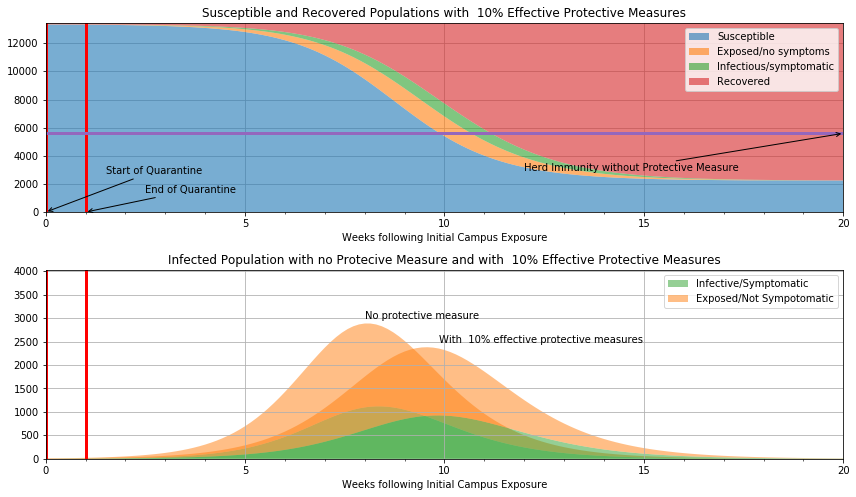

In [13]:
R0 = 2.4 
t_incubation = 5.1 #days
t_infective = 3.3 #days
N = Total_students 
false_negative_tests = 10 # %

print(n,N)
t_quarantine_i = 0  # day
t_test_i = 0
t_quarantine_e = 1
t_test_e = 5
u_quaratine = 80 # % efficacy of quarantine
u_transition = 40 # % efficacy of quarantine-PM transition while waiting for test
u_pm = 10 # % efficacy of protective measures
t_study = 140 # days
t_q = 14
eta = 20 # % symptomatic infected that quarantine



alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma
eta /= 100.
zeta = 1/t_q

# step function of protective measure
def u_step(t):
    if t < t_quarantine_i:
        ustep = 0
    elif (t >=  t_quarantine_i) and (t < t_quarantine_e):
        ustep = u_quaratine
    elif (t >= t_quarantine_e) and (t < t_quarantine_e + t_test_e):
        ustep = u_transition
    else:
        ustep = u_pm
    return ustep

# SEIR model differential equations.
def deriv(x, t, ucoef, alpha, beta, gamma,eta,zeta):
    s, e, i, q, r = x
    dsdt = -(1-ucoef*u_step(t)/100)*beta * s * i
    dedt =  (1-ucoef*u_step(t)/100)*beta * s * i - alpha * e
    didt = alpha * e - (gamma+eta) * i
    dqdt = eta*i - zeta*q
    drdt =  gamma * i
    return [dsdt, dedt, didt, dqdt, drdt]

if t_test_i == 0:
    # initial number of infected and recovered individuals
    
    e_initial = round(Total_infected*false_negative_tests/100)/N
    i_initial = 0.00
    r_initial = 0.00
    q_initial = Total_infected/N - e_initial
    s_initial = 1 - e_initial - i_initial - q_initial - r_initial
    x_initial = s_initial, e_initial, i_initial, q_initial, r_initial
    t = np.linspace(0, t_quarantine_e, t_quarantine_e+1)
    t_tot = np.copy(t)
    s, e, i, r = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma)).T
if t_test_i > 0:
    e_initial = Total_infected/N
    i_initial = 0.00
    r_initial = 0.00
    q_initial = 0.000
    s_initial = 1 - e_initial - i_initial - q_initial - r_initial
    x_initial = s_initial, e_initial, i_initial, q_initial, r_initial
    t = np.linspace(0, t_test_i, t_test_i+1)
    t_tot = np.copy(t)
    s, e, i, r = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma)).T
    print(i)
    E = round(e[-1]*N); I = round(i[-1]*N); R = round(r[-1]*N)
    E_false = round(E*false_negative_tests/100)
    I_false = round(I*false_negative_tests/100)
    R += (E-E_false) + (I-I_false)
    e_initial = E_false/N
    i_initial = I_false/N
    r_initial = R/N
    s_initial = 1 - e_initial - i_initial - r_initial
    x_initial = s_initial, e_initial, i_initial, r_initial
    t = np.linspace(t_test_i,t_quarantine_e, t_quarantine_e-t_test_i+1)
    t_tot = np.append(t_tot,t)
    s_q, e_q, i_q, r_q = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma)).T
    s = np.append(s,s_q); r = np.append(r,r_q); e = np.append(e,e_q); i = np.append(i,i_q)
    print(i,i_q)
t = np.linspace(t_quarantine_e, t_quarantine_e + t_test_e, t_test_e+1)
t_tot = np.append(t_tot,t)
x_initial = s[-1], e[-1], i[-1], r[-1]
s_q, e_q, i_q, r_q = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma)).T
s = np.append(s,s_q); r = np.append(r,r_q); e = np.append(e,e_q); i = np.append(i,i_q)
E = round(e[-1]*N); I = round(i[-1]*N); R = round(r[-1]*N)
E_false = round(E*false_negative_tests/100)
I_false = round(I*false_negative_tests/100)
R += (E-E_false) + (I-I_false)
e_initial = E_false/N
i_initial = I_false/N
r_initial = R/N
s_initial = 1 - e_initial - i_initial - r_initial
x_initial = s_initial, e_initial, i_initial, r_initial
t = np.linspace(t_quarantine_e + t_test_e, t_study, t_study-(t_quarantine_e+t_test_e)+1)
t_tot = np.append(t_tot,t)
x_initial = s[-1], e[-1], i[-1], r[-1]
s_q, e_q, i_q, r_q = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma)).T
s = np.append(s,s_q); r = np.append(r,r_q); e = np.append(e,e_q); i = np.append(i,i_q)


e_initial = round(Total_infected*false_negative_tests/100)/N
i_initial = 0.00
r_initial = Total_infected/N - e_initial
s_initial = 1 - e_initial - i_initial - r_initial
x_initial = s_initial, e_initial, i_initial, r_initial
t = np.linspace(0, t_study, t_study+1)
s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T
"""
At t_quarantine_e+t_test_result_e, 
the 1-false_negative_tests fraction of E and I goes to R, 
the rest is allowed to continue
"""

# plot the data
fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True), 
      fig.add_subplot(312)]

pal = sns.color_palette()

ax[0].stackplot(t_tot/7, N*s, N*e, N*i, N*r, colors=pal, alpha=0.6)
ax[0].set_title('Susceptible and Recovered Populations with {0:3.0f}% Effective Protective Measures'.format(u_pm))
ax[0].set_xlabel('Weeks following Initial Campus Exposure')
ax[0].set_xlim(0, t_tot[-1]/7)
ax[0].set_ylim(0, N)
ax[0].legend([
    'Susceptible', 
    'Exposed/no symptoms', 
    'Infectious/symptomatic',
    'Recovered'], 
    loc='best')
ax[0].plot(np.array([t_quarantine_i, t_quarantine_i]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([t_quarantine_e, t_quarantine_e]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='herd immunity')
ax[0].annotate("Start of Quarantine",
    (t_quarantine_i, 0), (t_quarantine_i + 1.5, N/5),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("End of Quarantine",
    (t_quarantine_e, 0), (t_quarantine_e + 1.5, N/10),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("Herd Immunity without Protective Measure",
    (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
    arrowprops=dict(arrowstyle='->'))

ax[1].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
ax[1].stackplot(t_tot/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
ax[1].set_title('Infected Population with no Protecive Measure and with {0:3.0f}% Effective Protective Measures'.format(u_pm))
ax[1].set_xlim(0, t_tot[-1]/7)
ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[1].set_xlabel('Weeks following Initial Campus Exposure')
ax[1].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic'],
    loc='upper right')
ax[1].plot(np.array([t_quarantine_i, t_quarantine_i]), ax[0].get_ylim(), 'r', lw=3)
ax[1].plot(np.array([t_quarantine_e, t_quarantine_e]), ax[0].get_ylim(), 'r', lw=3)

y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[1].annotate("No protective measure", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[1].annotate("With {0:3.0f}% effective protective measures ".format(u_pm), (t[k]/7, y[k] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()

In [ ]:
print(i_q)